
## Overview:

This notebook presents my efforts to construct a simple model with intensive feature extraction, primarily based on Sentence Transformers BERT. Despite its simplicity, resting on K-means, there is significant room for model refinement and complexity enhancement.In essence, the algorithm presented below forms an excellent foundational or baseline model for addressing the problem of clustering LinkedIn profiles into similar groups.

Here's a brief rundown of the algorithm:

     1 . Extract BERT embeddings for sentences or textual data.
     2 . Concat them into single vector.
     3 . Use t-SNE to find optimal number of dimensions that explains the data.
     4 . Reduce dimensionality using PCA.
     5 . Find the optimal number of clusters from K-means by using distortion metric.
     6 . Fit reduced data to optimal number of clusters extracted from the step above.
     7. Project Exctracted clusteres to original data.




In [41]:
from utils_li import *
from modeling_utils import *
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

##### Utils, helper functions for visualizations:

In [42]:
def plot_missing_data(df):
    # Calculating the percentage of missing values in each column
    missing_data = df.isnull().sum() / len(df) * 100

    # Filter out only columns with missing values
    missing_data = missing_data[missing_data != 0]

    # Sort the missing data in descending order
    missing_data.sort_values(ascending=False, inplace=True)

    plt.figure(figsize=(6, 6))
    sns.barplot(y=missing_data.index, x=missing_data)
    plt.title('Percentage of Missing Data by Feature')
    plt.xlabel('Percentage Missing (%)')
    plt.ylabel('Features')
    plt.show()

def visualize_normalized_histogram(df, column, top_n=100, figsize=(6, 20)):
    value_counts = df[column].value_counts().nlargest(top_n)
    value_counts_normalized = (value_counts / len(df) * 100).sort_values(
        ascending=True)  # sort values in ascending order

    colors = plt.cm.get_cmap('tab20')(np.arange(top_n))[::-1]  # reverse color array

    plt.figure(figsize=figsize)
    plt.barh(value_counts_normalized.index, value_counts_normalized.values, color=colors)
    plt.ylabel(column)
    plt.xlabel('Percentage')
    plt.title(f'Normalized Value Counts Histogram of {column} (Top {top_n})')
    plt.xticks(rotation=0)
    plt.show()

def visualize_top_15_category_histogram(data, category_column, cluster_column, top, title, width, height):
    top_n_categories = data[category_column].value_counts().nlargest(top).index.tolist()
    filtered_data = data[data[category_column].isin(top_n_categories)]

    fig, ax = plt.subplots(
        figsize=(width / 80, height / 80))  # convert width and height from pixels to inches for matplotlib
    sns.histplot(data=filtered_data, x=category_column, hue=cluster_column, multiple="stack", ax=ax)

    ax.set_title(title)
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_fontsize(10)
    plt.show()


def get_latest_dates(df):
    df['sort_key'] = np.where(df['date_to'] == 0, df['date_from'], df['date_to'])
    df = df.sort_values(['member_id', 'sort_key'], ascending=[True, False])
    latest_dates = df.groupby('member_id').first().reset_index()
    latest_dates = latest_dates.drop(columns=['sort_key'])

    return latest_dates

##### Utils, helper functions for preprocessing:

In [ ]:
def transform_experience_dates(experience):
    def transform_date_format(date_value):
        try:
            if isinstance(date_value, int) or date_value.isdigit():
                return str(date_value)  # Return the integer or numeric string as is
            else:
                date_string = str(date_value)
                date_object = datetime.strptime(date_string, "%b-%y")
                return date_object.strftime("%Y-%m")  # Format with year and month only
        except ValueError:
            return None

    def extract_year(value):
        if isinstance(value, str):
            pattern = r'\b(\d{4})\b'  # Regular expression pattern to match a four-digit year
            match = re.search(pattern, value)
            if match:
                return str(match.group(1))
        return None

    experience['transformed_date_from'] = experience['date_from'].apply(transform_date_format)
    experience['transformed_date_to'] = experience['date_to'].apply(transform_date_format)

    experience.loc[experience['transformed_date_from'].isnull(), 'transformed_date_from'] = experience.loc[
        experience['transformed_date_from'].isnull(), 'date_from'].apply(extract_year)
    experience.loc[experience['transformed_date_to'].isnull(), 'transformed_date_to'] = experience.loc[
        experience['transformed_date_to'].isnull(), 'date_to'].apply(extract_year)

    experience['transformed_date_from'] = experience['transformed_date_from'].str.replace(r'-\d{2}$', '', regex=True)
    experience['transformed_date_to'] = experience['transformed_date_to'].str.replace(r'-\d{2}$', '', regex=True)

    return experience

##### Utils, helper functions for modeling:

In [93]:
def find_optimal_dimensions_tsne(data, perplexity_range):
    dims = []
    scores = []

    max_dim = min(3, data.shape[1] - 1)

    for dim in range(1, max_dim + 1):
        if dim > len(perplexity_range):
            break

        tsne = TSNE(n_components=dim)
        embeddings = tsne.fit_transform(data)

        dims.append(dim)
        scores.append(tsne.kl_divergence_)

    # Plot the KL divergence scores
    plt.plot(dims, scores, marker='o')
    plt.xlabel('Number of dimensions')
    plt.ylabel('KL Divergence Score')
    plt.title('t-SNE: KL Divergence')
    plt.show()

    optimal_dim_index = scores.index(min(scores))
    optimal_dimensions = dims[optimal_dim_index]

    return optimal_dimensions


def reduce_dimensionality_with_pca(data, components):
    pca = PCA(n_components=components)
    reduced_data = pca.fit_transform(data)
    return reduced_data


def fit_kmeans_and_evaluate(data, n_clusters=4, n_init=100, max_iter=400, init='k-means++', random_state=42):
    data_copy = data.copy()

    kmeans_model = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, init=init, random_state=random_state)
    kmeans_model.fit(data_copy)

    silhouette = silhouette_score(data_copy, kmeans_model.labels_, metric='euclidean')
    print('KMeans Scaled Silhouette Score: {}'.format(silhouette))

    labels = kmeans_model.labels_
    clusters = pd.concat([data_copy, pd.DataFrame({'cluster_scaled': labels})], axis=1)

    return clusters

####  Basic Employee Features:

In [43]:

basic_features = pd.read_csv("Clean Data/basic_features.csv")
basic_features['member_id'] = basic_features['member_id'].astype(str)
basic_features.replace("none",np.NAN,inplace=True)


####  Employees Education:

In [44]:

education = pd.read_csv("Clean Data/employees_education_cleaned.csv")
# transform member_id to string for ease of use
education["member_id"] = education["member_id"].astype(str)
education = education[education["member_id"].isin(basic_features["member_id"])]



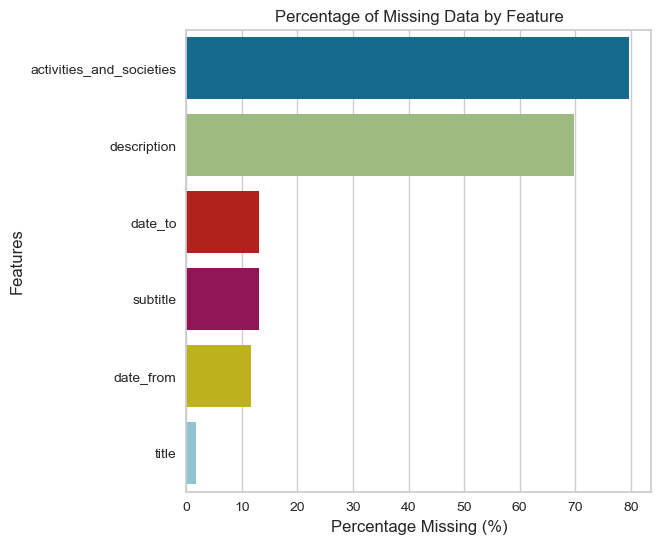

In [45]:

plot_missing_data(education)


In [46]:


education.drop(["activities_and_societies","description"],axis=1,inplace=True)
education[["date_from","date_to"]] = education[["date_from","date_to"]].fillna(0)
education[["date_from","date_to"]] = education[["date_from","date_to"]].astype(int)
education[["title","subtitle"]] = education[["title","subtitle"]].fillna("none")



In [47]:

# get the latest employee education obtained per member_id:
latest_education = get_latest_dates(education)


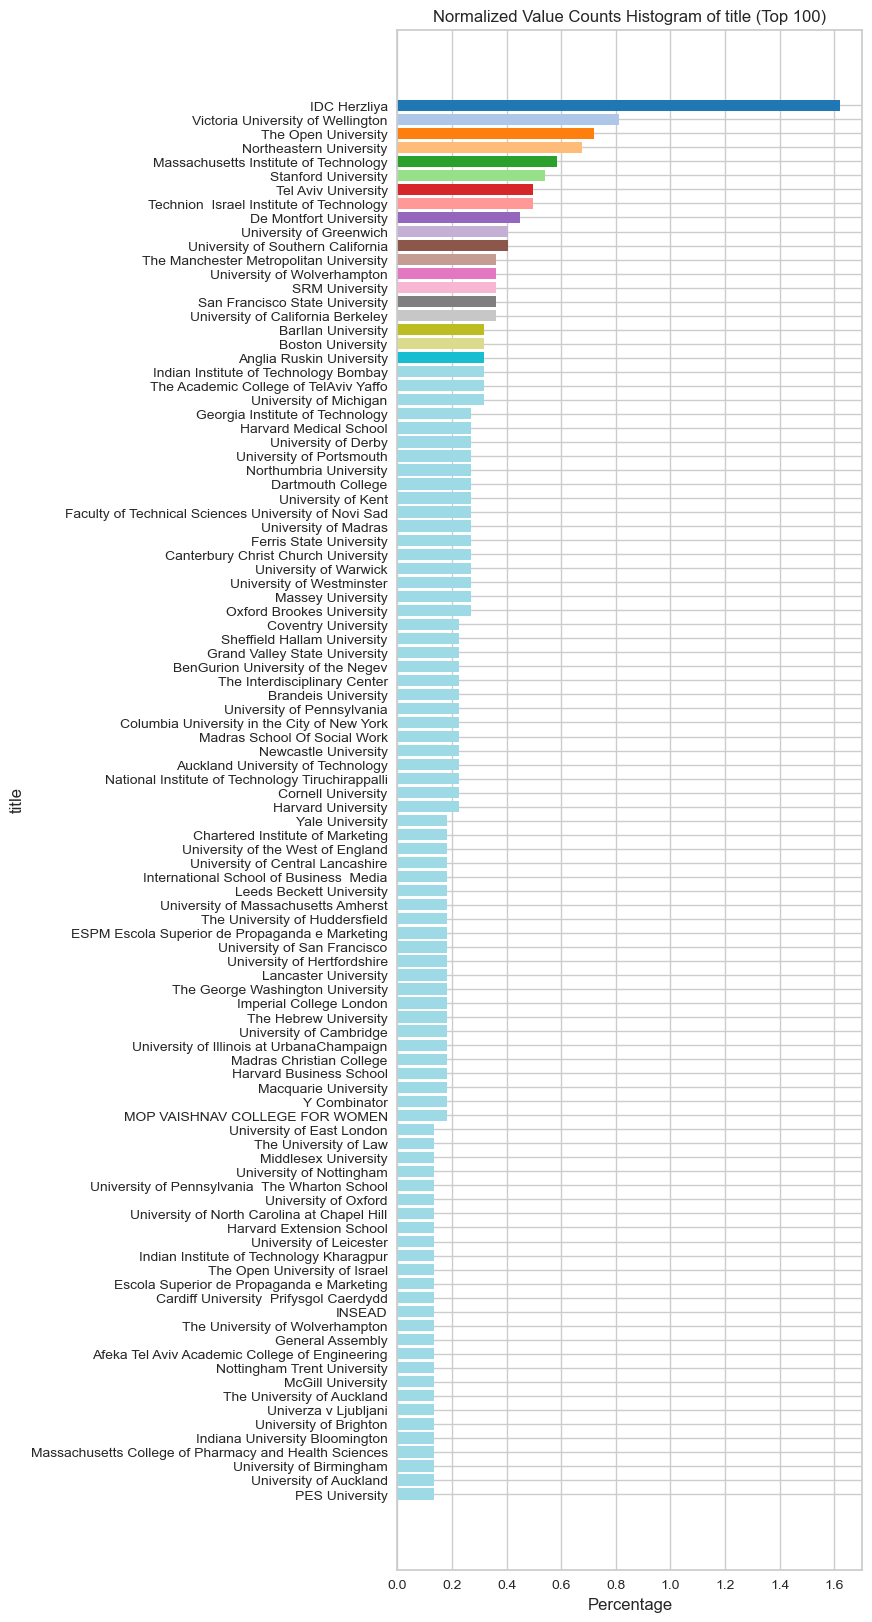

In [48]:
visualize_normalized_histogram(latest_education, 'title', top_n=100)

In [49]:
latest_education_drop_nan = latest_education.copy()
latest_education_drop_nan = latest_education_drop_nan[latest_education_drop_nan["subtitle"] != 'none']

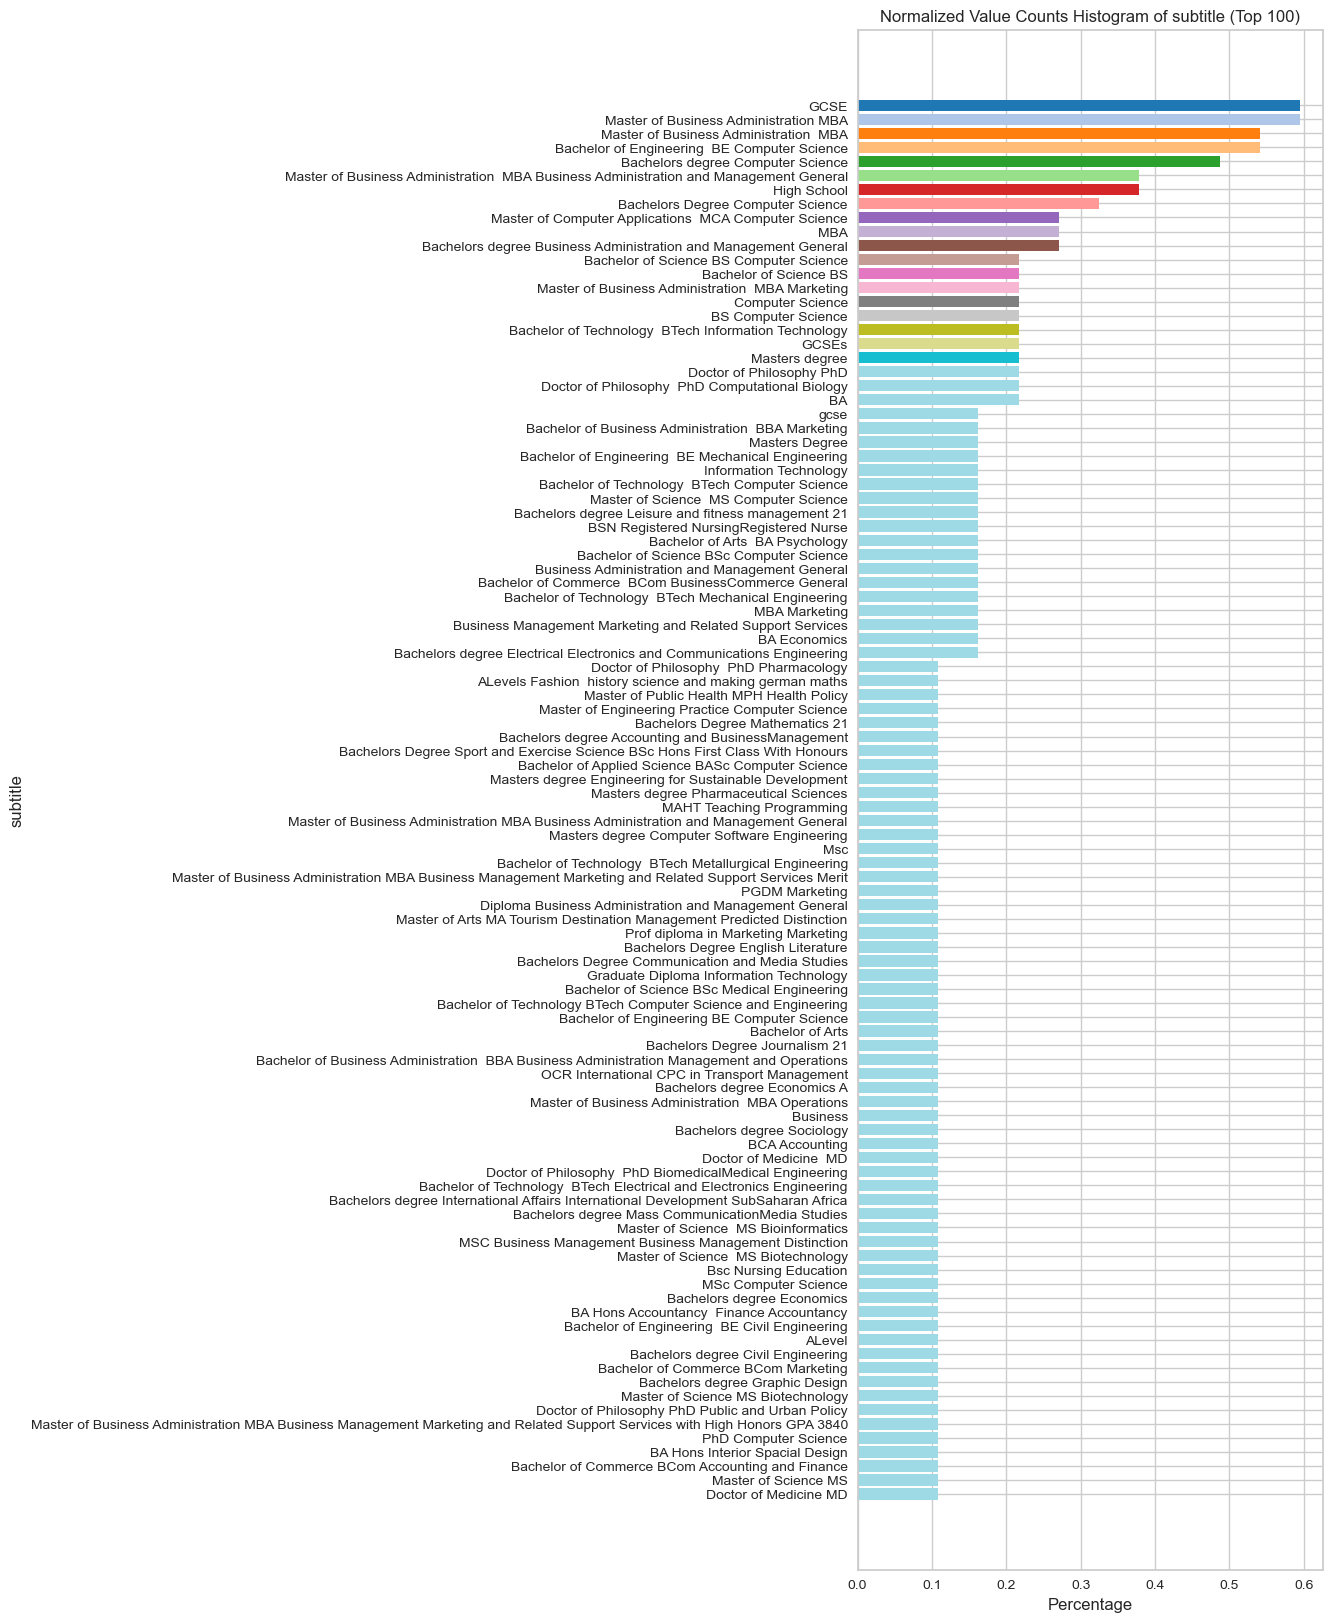

In [50]:
# None is causing a problem it might influence the segmentation algorithm:
visualize_normalized_histogram(latest_education_drop_nan, 'subtitle', top_n=100)

####  Employees Experience:

In [51]:
experience  = pd.read_csv("Clean Data/employees_experience_cleaned.csv")
# transform member_id to string for ease of use
experience["member_id"] = experience["member_id"].astype(str)
experience = experience[experience["member_id"].isin(experience["member_id"])]

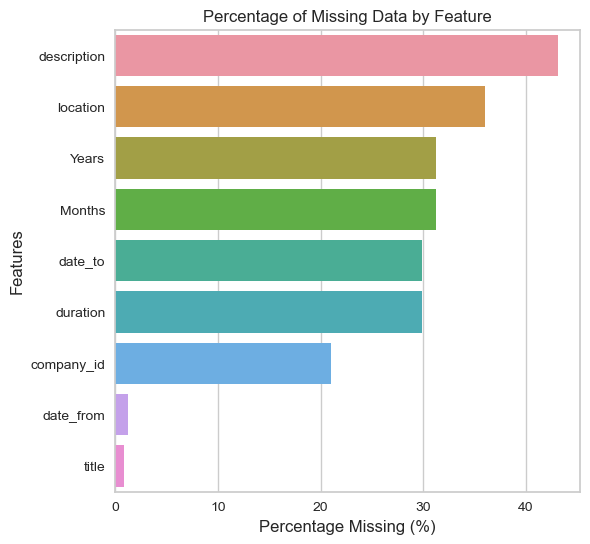

In [52]:
plot_missing_data(experience)

In [53]:
experience.drop(["description","location","Years","Months","duration","company_id"],axis=1,inplace=True, errors="ignore")
experience[["date_from","date_to"]] = experience[["date_from","date_to"]].fillna(0)
experience["title"] = experience["title"].fillna("none")
experience.drop_duplicates(inplace=True)

In [54]:
experience = transform_experience_dates(experience)

In [55]:
experience = experience[["member_id","title","transformed_date_from","transformed_date_to"]]
experience.rename(columns={'transformed_date_from': 'date_from', 'transformed_date_to': 'date_to'},inplace=True)

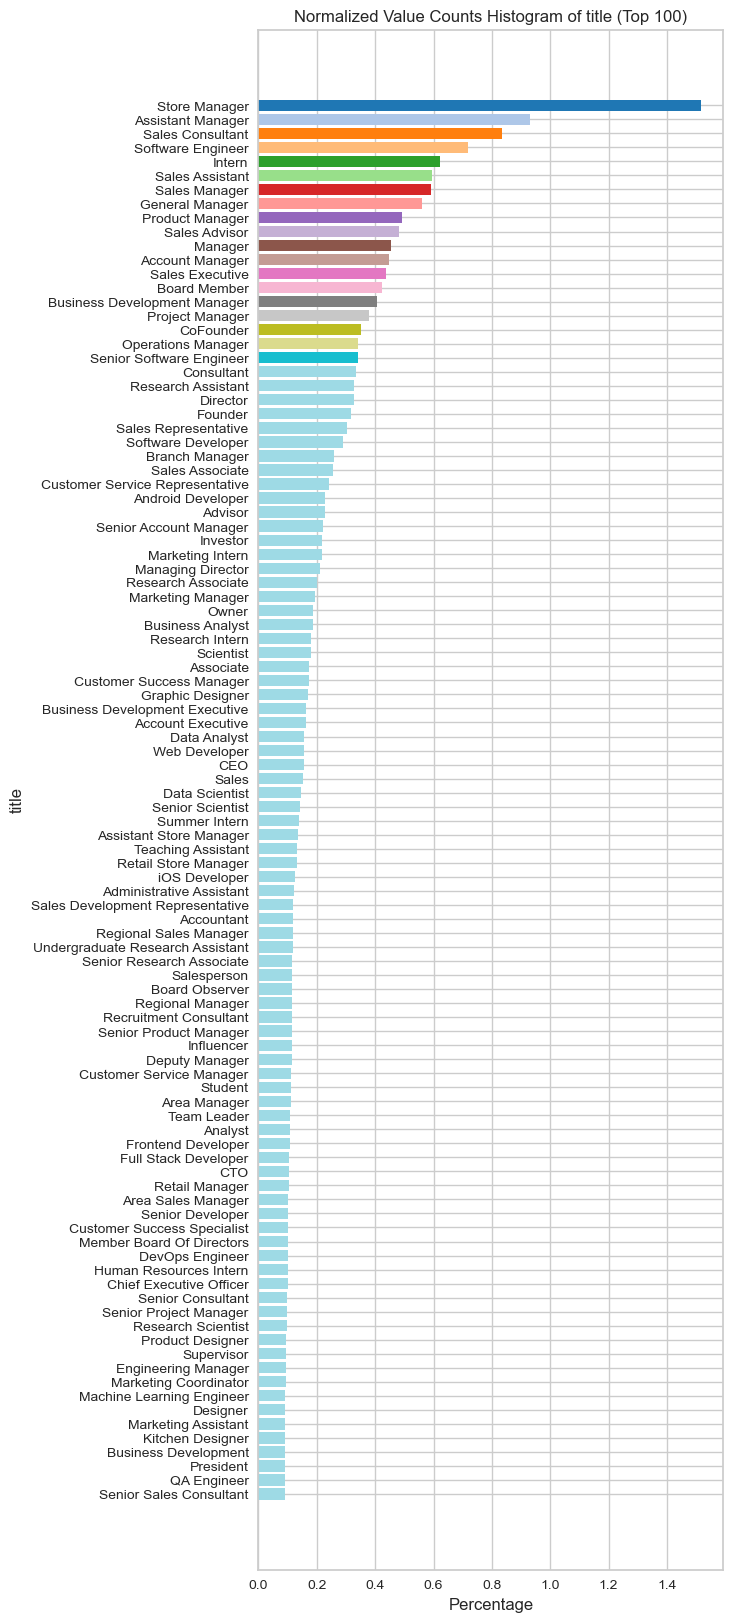

In [56]:
visualize_normalized_histogram(experience[experience["title"]!="none"], 'title', top_n=100)

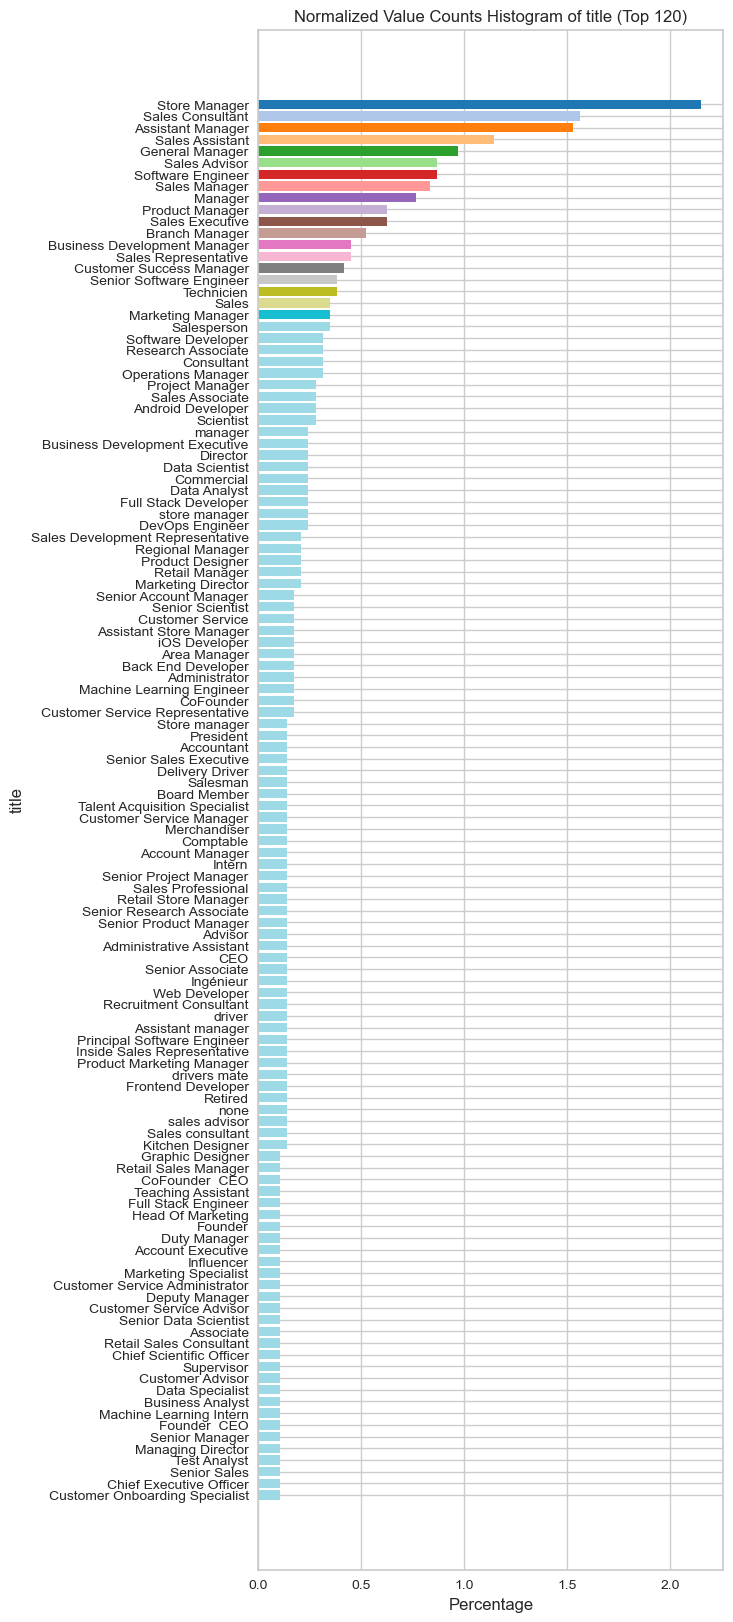

In [57]:
latest_experience = get_latest_dates(experience)
visualize_normalized_histogram(latest_experience, 'title', top_n=120)

####  Basic Features:

In [58]:
basic_features.isnull().sum()

member_id                   0
title                      75
location                    2
industry                 1175
summary                  1399
recommendations_count       0
country                     0
connections_count           0
experience_count            0
latitude                    0
longitude                   0
months experience        1460
number of positions      1460
number of degrees         660
years of educations       660
dtype: int64

###### Remove columns with high percentage of missing values as they affect the results of cluster:

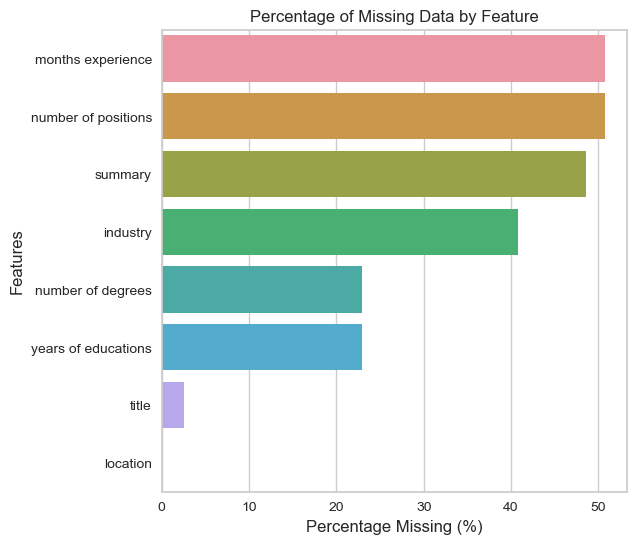

In [59]:
plot_missing_data(basic_features)

In [60]:
basic_features["industry"] = basic_features["industry"].fillna("other")
basic_features["title"] = basic_features["title"].fillna("other")
basic_features["location"] = basic_features["location"].fillna("unknown")
basic_features[["number of degrees","years of educations"]] =  basic_features[["number of degrees","years of educations"]].fillna("0")
basic_features.drop(["months experience","number of positions","summary"],axis=1,inplace=True)
basic_features.head(10)

member_id                                              title  \
0   4665483           Ingénieur technico commercial chez Engie   
1   5222619                      Manager at Harveys Furnishing   
2   5504049                Sales Manager at Harveys Furnishing   
3   6704970            Assistant Manager at Harveys Furnishing   
4   8192070  I Help Professionals Make Career  Business Bre...   
5   8273835                                   Furniture Retail   
6   9940377                Sr Research Engineer at BAMF Health   
7  11076570                Head of New Business at Cube Online   
8  15219102       Veneer Sales Manager at Mundy Veneer Limited   
9  15809688  Senior Scientist  Computational Biology at Boe...   

                                  location                           industry  \
0          Nanterre, Île-de-France, France                            Banking   
1                           United Kingdom                          Furniture   
2          Bridgend, Wales, United Kingdom                          Furniture   
3   Greater Guildford Area, United Kingdom                          Furniture   
4             Dallas, Texas, United States  Information Technology & Services   
5                           United Kingdom                              other   
6    Grand Rapids, Michigan, United States                     Medical Device   
7       Sydney, New South Wales, Australia                    Events Services   
8         Taunton, England, United Kingdom                          Furniture   
9  Cambridge, Massachusetts, United States                              other   

   recommendations_count         country  connections_count  experience_count  \
0                    0.0          France                 13                 1   
1                    0.0  United Kingdom                 19                 1   
2                    0.0  United Kingdom                  0                 1   
3                    0.0  United Kingdom                 31                 1   
4                   26.0   United States              65535                16   
5                    0.0  United Kingdom                146                 4   
6                    0.0   United States                288                 7   
7                    0.0       Australia              65535                10   
8                    0.0  United Kingdom                179                 6   
9                    0.0   United States                440                 4   

    latitude   longitude number of degrees years of educations  
0  48.892423    2.215331                 0                   0  
1  55.378051   -3.435973               1.0                 0.0  
2  51.504286   -3.576945               2.0                 7.0  
3  51.236220   -0.570409                 0                   0  
4  32.776664  -96.796988               3.0                 8.0  
5  55.378051   -3.435973               1.0                 6.0  
6  42.963360  -85.668086               7.0                15.0  
7 -33.868820  151.209295               2.0                 5.0  
8  51.015344   -3.106849               2.0                 4.0  
9  42.373616  -71.109733               2.0                 9.0

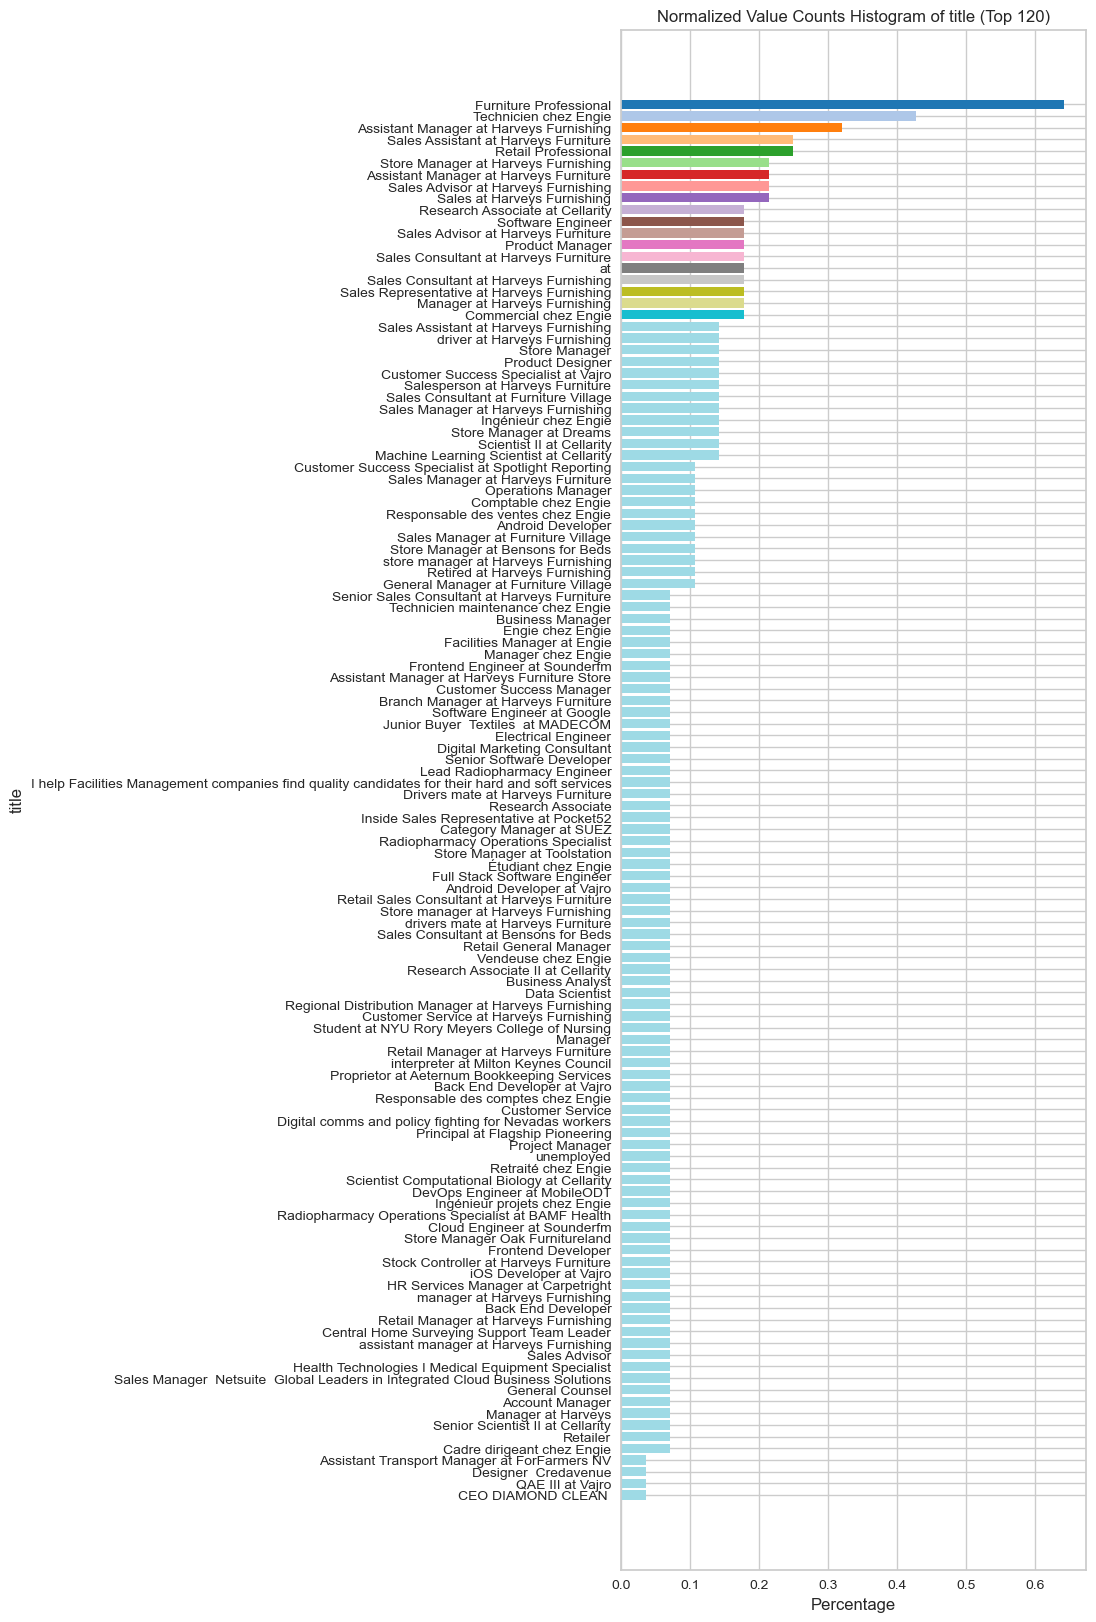

In [61]:
visualize_normalized_histogram(basic_features[basic_features["title"]!="other"],"title",top_n=120)

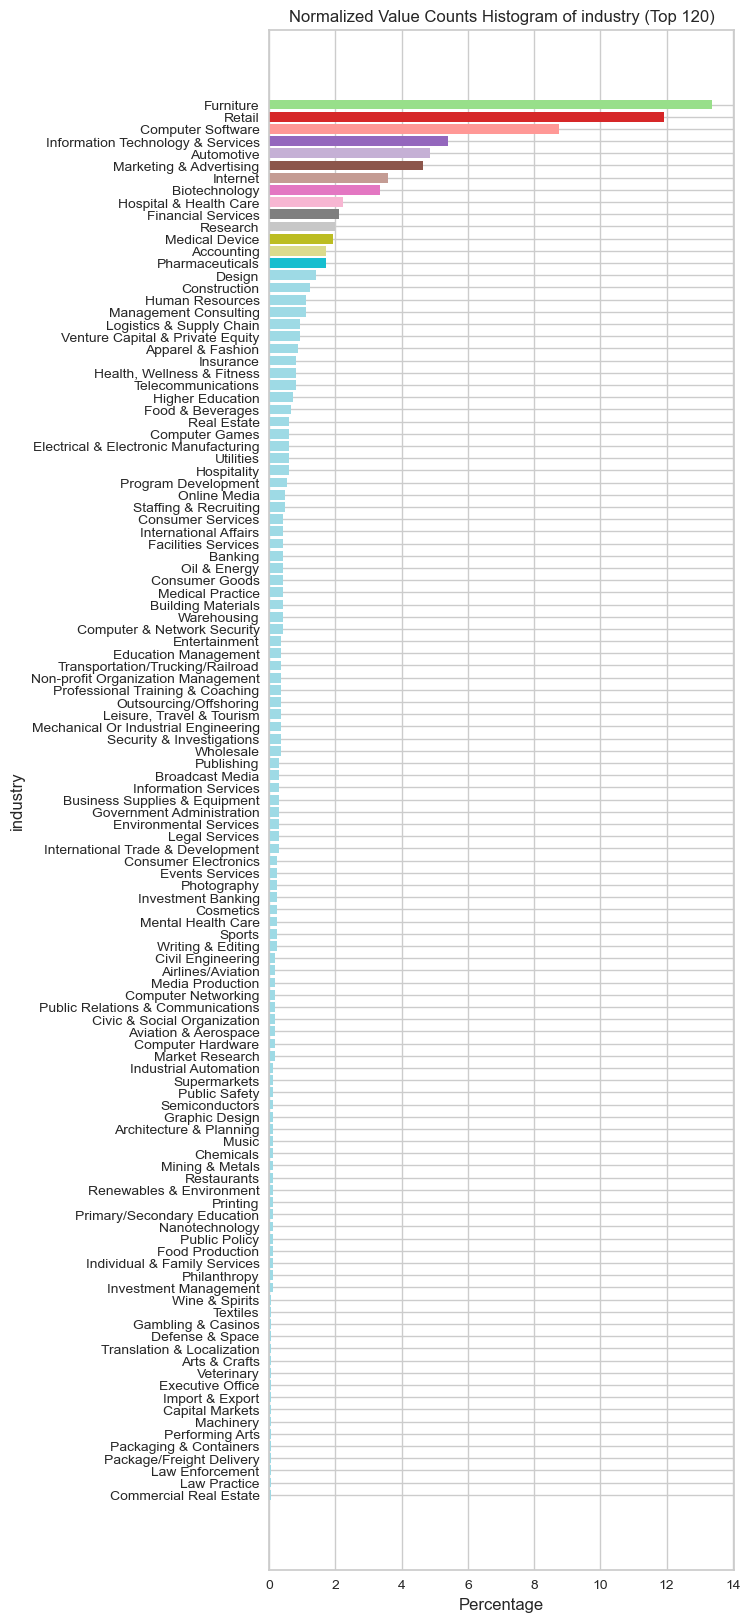

In [62]:
visualize_normalized_histogram(basic_features[basic_features["industry"]!="other"],"industry",top_n=120)

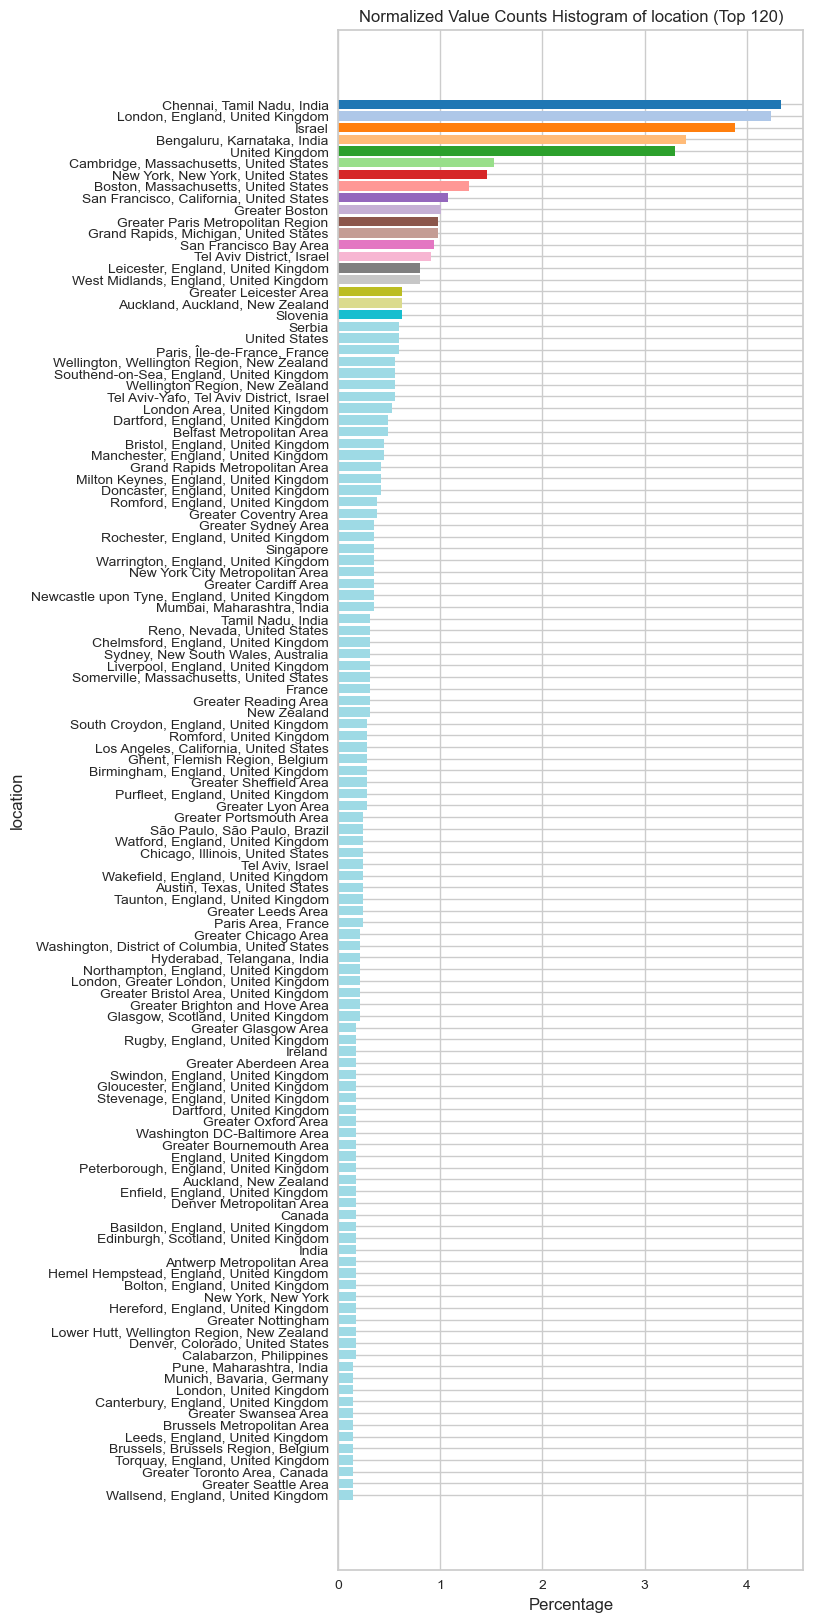

In [63]:
visualize_normalized_histogram(basic_features,"location",top_n=120)

###### Merge employees basic features, the latest education and experience:

In [64]:
latest_experience.drop(["date_from","date_to"],axis=1,inplace=True,errors="ignore")
latest_experience.rename(columns={"title":"experience_title"}, inplace=True)
latest_experience.head(10)

member_id                         experience_title
0  1000769811                   Sales  Channel Advisor
1  1001027856            Product Development Assistant
2  1001731893                                    VP RD
3  1002107022  Digital Marketing  Ecommerce Consultant
4  1002900696                           Branch Manager
5  1003503234                    Founding Shareholder 
6  1004617047                                      RRH
7  1004931912    Senior Product Development Specialist
8  1005561303                         Sales consultant
9   100559115                 Marketing B2B Specialist

In [65]:
latest_education.drop(["date_from","date_to"],axis=1,inplace=True,errors="ignore")
latest_education.rename(columns={"title":"education_title","subtitle":"education_subtitle"}, inplace=True)
latest_education.head(10)

member_id                         education_title  \
0  1000769811  University of California Santa Barbara   
1  1001027856      British Academy of Interior Design   
2  1001731893   The Academic College of TelAviv Yaffo   
3  1002107022                   Epping forest college   
4  1002900696             bridge road adult education   
5  1003503234                    Lancaster University   
6  1004617047              Université Paris II  Assas   
7  1004931912                  University of Michigan   
8  1005561303                   Rother Valley College   
9   100559115                                CONMEBOL   

                                  education_subtitle  
0       BA Business EconomicsPhilosophy Double Major  
1               Postgraduate Diploma Interior Design  
2                                   Computer Science  
3                        2 A levels Computer studies  
4  OCN Psychology criminal Psychology Psychosocia...  
5                             BSc Hons in Management  
6  Master II Droit et pratique des relations du t...  
7  Post doc Radiopharmaceutical Chemistry in Nucl...  
8  Btec diploma in business  finance business pas...  
9                         Certified Sports Managment

In [66]:
overall_features  = basic_features.merge(latest_education, on='member_id', how='outer').merge(latest_experience, on='member_id', how='outer')
overall_features.head(20)

member_id                                              title  \
0    4665483           Ingénieur technico commercial chez Engie   
1    5222619                      Manager at Harveys Furnishing   
2    5504049                Sales Manager at Harveys Furnishing   
3    6704970            Assistant Manager at Harveys Furnishing   
4    8192070  I Help Professionals Make Career  Business Bre...   
5    8273835                                   Furniture Retail   
6    9940377                Sr Research Engineer at BAMF Health   
7   11076570                Head of New Business at Cube Online   
8   15219102       Veneer Sales Manager at Mundy Veneer Limited   
9   15809688  Senior Scientist  Computational Biology at Boe...   
10  21059859                   ML  Genomics  Datadriven biology   
11  22825932                          Assistant Manager Harveys   
12  23378337                Industrial IoT Solutions Consultant   
13  24620931                       ExGeneral Manager at AHFFABB   
14  25021590  Senior Director Therapeutic Area Expansion at ...   
15  27382998  Physician scientist working at interesection o...   
16  27540066    Business manager at ScS  Sofa Carpet Specialist   
17  27673065  Sr Bioinformatics Scientist NGS Technologies a...   
18  28161267                                Retail Professional   
19  29195709                   Strategic Partnerships at Stripe   

                                   location  \
0           Nanterre, Île-de-France, France   
1                            United Kingdom   
2           Bridgend, Wales, United Kingdom   
3    Greater Guildford Area, United Kingdom   
4              Dallas, Texas, United States   
5                            United Kingdom   
6     Grand Rapids, Michigan, United States   
7        Sydney, New South Wales, Australia   
8          Taunton, England, United Kingdom   
9   Cambridge, Massachusetts, United States   
10  Cambridge, Massachusetts, United States   
11          St Osyth, Essex, United Kingdom   
12          Denver, Colorado, United States   
13          London, England, United Kingdom   
14     Boston, Massachusetts, United States   
15                     Greater Chicago Area   
16                           United Kingdom   
17                           Greater Boston   
18                  Greater Colchester Area   
19        New York, New York, United States   

                             industry  recommendations_count         country  \
0                             Banking                    0.0          France   
1                           Furniture                    0.0  United Kingdom   
2                           Furniture                    0.0  United Kingdom   
3                           Furniture                    0.0  United Kingdom   
4   Information Technology & Services                   26.0   United States   
5                               other                    0.0  United Kingdom   
6                      Medical Device                    0.0   United States   
7                     Events Services                    0.0       Australia   
8                           Furniture                    0.0  United Kingdom   
9                               other                    0.0   United States   
10                  Computer Software                    0.0   United States   
11                             Retail                    0.0  United Kingdom   
12              Industrial Automation                    0.0   United States   
13                          Furniture                    0.0  United Kingdom   
14                      Biotechnology                    0.0   United States   
15                    Pharmaceuticals                    0.0   United States   
16                             Retail                    0.0  United Kingdom   
17                           Research                    1.0   United States   
18                             Retail                    0.0  United Kingdom   
19     

###### additional preprocessing:

In [67]:
string_columns = ["education_title",
                  "country",
                  "industry",
                  "location",
                  "title",
                  "education_subtitle",
                  "experience_title"]
overall_features[string_columns] = overall_features[string_columns].fillna('none')

numerical_cols = ["experience_count",
                  "connections_count",
                  "years of educations",
                  "number of degrees",
                  "recommendations_count",
                  "longitude",
                  "latitude"]
overall_features[numerical_cols] = overall_features[numerical_cols].fillna(0)
overall_features.isnull().sum()

member_id                0
title                    0
location                 0
industry                 0
recommendations_count    0
country                  0
connections_count        0
experience_count         0
latitude                 0
longitude                0
number of degrees        0
years of educations      0
education_title          0
education_subtitle       0
experience_title         0
dtype: int64

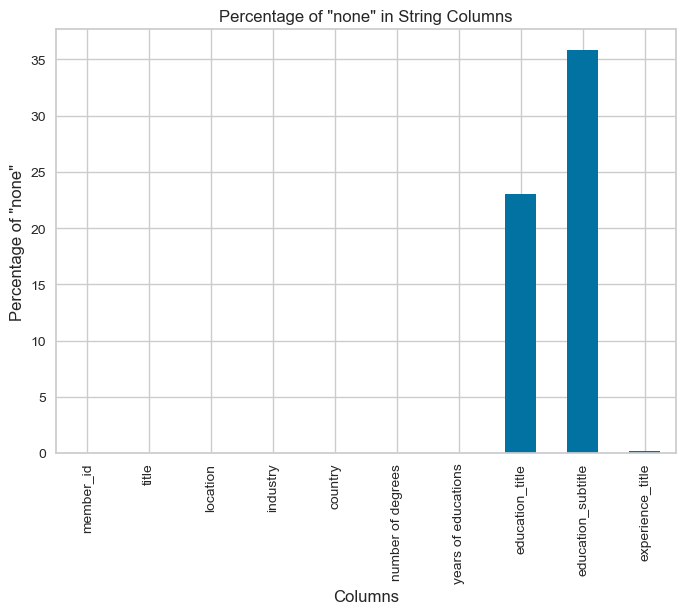

In [68]:
visualize_none_percentages(overall_features)

###### Drop rows that contain "none" as it effects the performance of Clustering:


In [69]:
overall_features = overall_features[~overall_features.apply(lambda row: row.astype(str).str.contains('none')).any(axis=1)]
overall_features = overall_features[~overall_features.apply(lambda row: row.astype(str).str.contains('other')).any(axis=1)]
overall_features[["title","industry","location","country","education_title","education_subtitle","experience_title"]].head(5).style.background_gradient()

######  Extract Sentence Embeddings:

In [70]:
### extract high dimensional embeddings using sentence transformer BERT:
title_embeddings = get_embeddings(overall_features,'title')
industry_embeddings = get_embeddings(overall_features,'industry')
location_embeddings = get_embeddings(overall_features,'location')
country_embeddings = get_embeddings(overall_features,'country')
education_title = get_embeddings(overall_features,'education_title')
education_subtitle = get_embeddings(overall_features,'education_subtitle')
experience_title = get_embeddings(overall_features,'experience_title')

######  Merge with simple features:

In [71]:
merged_embeddings = np.concatenate((
    title_embeddings,
    industry_embeddings,
    location_embeddings,
    country_embeddings,
    education_title,
    education_subtitle,
    experience_title
), axis=1)

additional_numerical_features = overall_features[[
    'recommendations_count',
    'connections_count',
    'experience_count',
    'latitude',
    'longitude',
    'member_id'
]].values

simple_features = basic_features[['recommendations_count',
                                  'connections_count',
                                  'experience_count',
                                  'latitude',
                                  'longitude', ]]

final_data = np.concatenate((merged_embeddings, additional_numerical_features), axis=1)
final_data = pd.DataFrame(final_data)


# keep a list or ordered members_ids to use later for explanations:
members_ids = final_data.iloc[:, -1].tolist()

# drop members_id, as it's not used in modeling the data, and it will lead to misleading results:
final_data = final_data.drop(final_data.columns[-1], axis=1)

###### Find Optimal Number of Components:

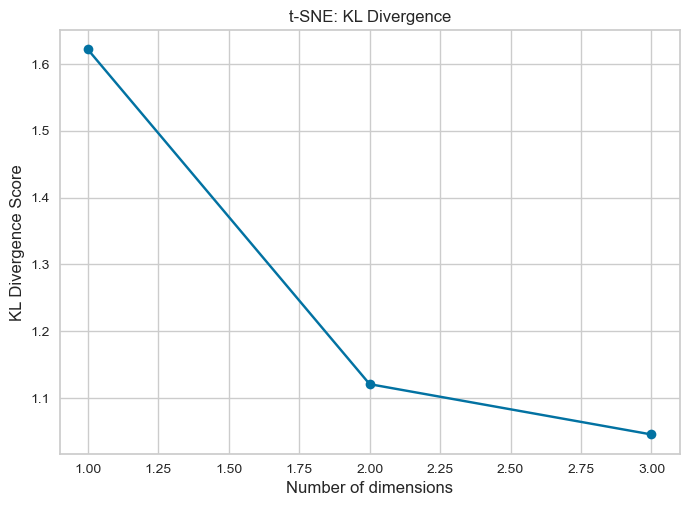

3

In [72]:
find_optimal_dimensions_tsne(merged_embeddings, [5,10,15,20,25,30,35,40,45,50])

######  Reduce Embedding Dimensionality:

In [73]:
reduced_merged_embeddings = reduce_dimensionality_with_pca(merged_embeddings,3)
reduced_merged_embeddings = pd.DataFrame(reduced_merged_embeddings)
reduced_merged_embeddings

0         1         2
0    -0.309824 -0.357302  0.296566
1    -0.611905 -0.678734 -0.044584
2     0.103592  0.197899  0.296579
3     0.664791 -0.113497  0.114943
4    -0.656240 -0.552984  0.348519
...        ...       ...       ...
1140  0.779930 -0.071203  0.002138
1141  0.859704 -0.109584 -0.098612
1142 -0.502135  0.747044  0.863029
1143  0.561427 -0.077284 -0.185717
1144 -0.542131  0.734136 -0.657090

[1145 rows x 3 columns]

###### Scale Simple Numerical Features:

In [74]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(simple_features)
scaled_data = pd.DataFrame(scaled_data)

######  Merge with Reduced Embedding Vectors:

In [75]:
merged_embeddings = pd.DataFrame(merged_embeddings)
all_features = pd.concat([merged_embeddings, scaled_data], axis=1)

###### Find optimal number of K that describes the data with the smallest distortion score:

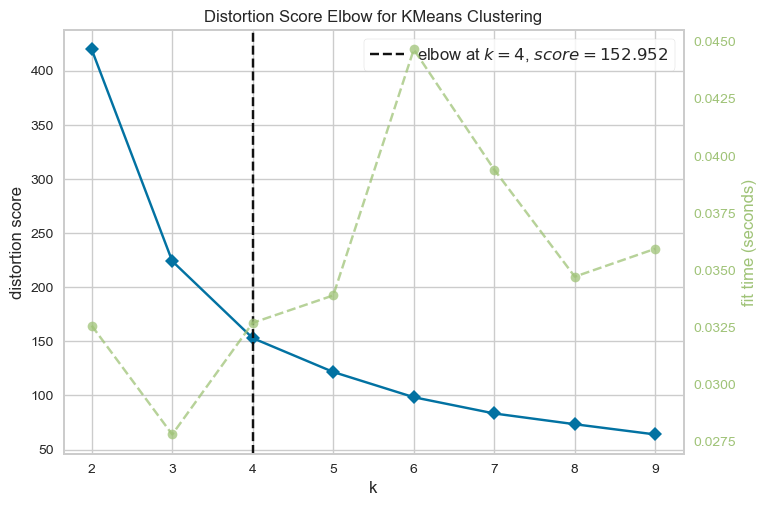

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [76]:
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(reduced_merged_embeddings)
visualizer.show()

In [77]:
merged_embeddings_clusters = fit_kmeans_and_evaluate(reduced_merged_embeddings,4,n_init=100,max_iter=100000, init='k-means++',random_state=412)

KMeans Scaled Silhouette Score: 0.5201332569122314


In [78]:
# rename extracted clusters:
merged_embeddings_clusters = merged_embeddings_clusters.rename(columns={0:"component 1",
                                                                        1:"component 2",
                                                                        2:"component 3"})
merged_embeddings_clusters["member_id"] = members_ids

In [80]:
overall_features["member_id"] = overall_features["member_id"].astype(int)
merged_embeddings_clusters["member_id"] = merged_embeddings_clusters["member_id"].astype(int)
overall_results = overall_features.merge(merged_embeddings_clusters,on='member_id')
overall_results["cluster_scaled_string"] = overall_results["cluster_scaled"].astype(str)
overall_results.head(10)


member_id                                              title  \
0    8192070  I Help Professionals Make Career  Business Bre...   
1    9940377                Sr Research Engineer at BAMF Health   
2   11076570                Head of New Business at Cube Online   
3   15219102       Veneer Sales Manager at Mundy Veneer Limited   
4   21059859                   ML  Genomics  Datadriven biology   
5   22825932                          Assistant Manager Harveys   
6   23378337                Industrial IoT Solutions Consultant   
7   25021590  Senior Director Therapeutic Area Expansion at ...   
8   27382998  Physician scientist working at interesection o...   
9   27540066    Business manager at ScS  Sofa Carpet Specialist   

                                  location                           industry  \
0             Dallas, Texas, United States  Information Technology & Services   
1    Grand Rapids, Michigan, United States                     Medical Device   
2       Sydney, New South Wales, Australia                    Events Services   
3         Taunton, England, United Kingdom                          Furniture   
4  Cambridge, Massachusetts, United States                  Computer Software   
5          St Osyth, Essex, United Kingdom                             Retail   
6          Denver, Colorado, United States              Industrial Automation   
7     Boston, Massachusetts, United States                      Biotechnology   
8                     Greater Chicago Area                    Pharmaceuticals   
9                           United Kingdom                             Retail   

   recommendations_count         country  connections_count  experience_count  \
0                   26.0   United States              65535                16   
1                    0.0   United States                288                 7   
2                    0.0       Australia              65535                10   
3                    0.0  United Kingdom                179                 6   
4                    0.0   United States                 45                 1   
5                    0.0  United Kingdom                218                 6   
6                    0.0   United States              65535                 4   
7                    0.0   United States              65535                15   
8                    0.0   United States              65535                12   
9                    0.0  United Kingdom                395                 8   

    latitude   longitude number of degrees years of educations  \
0  32.776664  -96.796988               3.0                 8.0   
1  42.963360  -85.668086               7.0                15.0   
2 -33.868820  151.209295               2.0                 5.0   
3  51.015344   -3.106849               2.0                 4.0   
4  42.373616  -71.109733               4.0                16.0   
5  51.799152    1.075842               1.0                 3.0   
6  39.739236 -104.990251               1.0                 4.0   
7  42.360082  -71.058880               5.0                16.0   
8  41.743507  -88.011847               6.0                27.0   
9  55.378051   -3.435973               1.0                 0.0   

                         education_title  \
0                     Harvard University   
1          Grand Valley State University   
2      University of the West of England   
3                 Northumbria University   
4         Technical University of Munich   
5  Sallynoggin University Dublin Ireland   
6                  LeTourneau University   
7            Wharton Executive Education   
8     Yale University School of Medicine   
9                    University of Leeds   

                                  education_subtitle  \
0  Bachelor of Arts BA Computer Science  Focus on...   
1  Master of Science Engineering  Biomedical Engi...   
2                           BA Hons Business Studies   
3   Masters Degree MSc Hons Business with Man

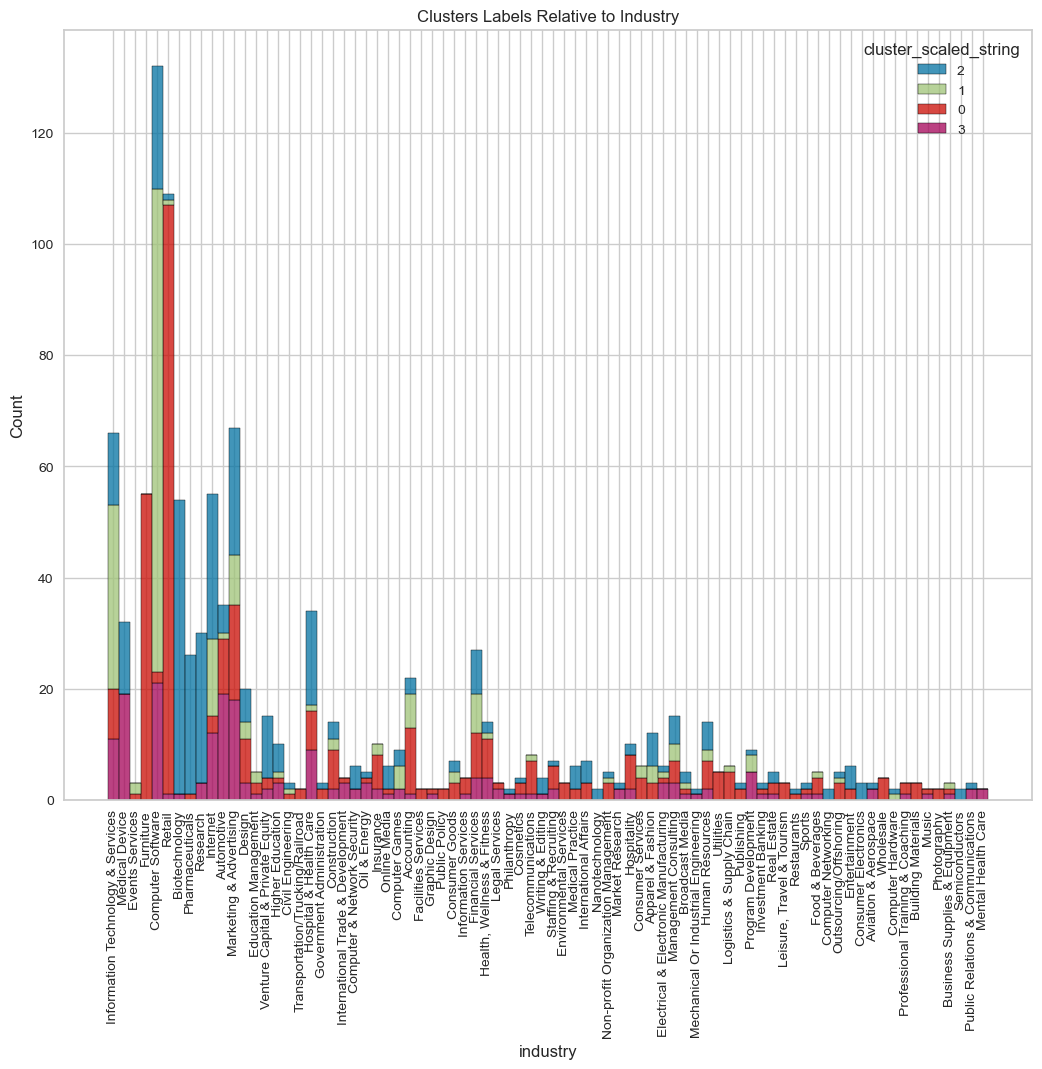

In [81]:
visualize_top_15_category_histogram(overall_results,
                                    category_column="industry",
                                    cluster_column="cluster_scaled_string",
                                    top=80,
                                    title="Clusters Labels Relative to Industry",
                                    width=1000,
                                    height=800
                                    )

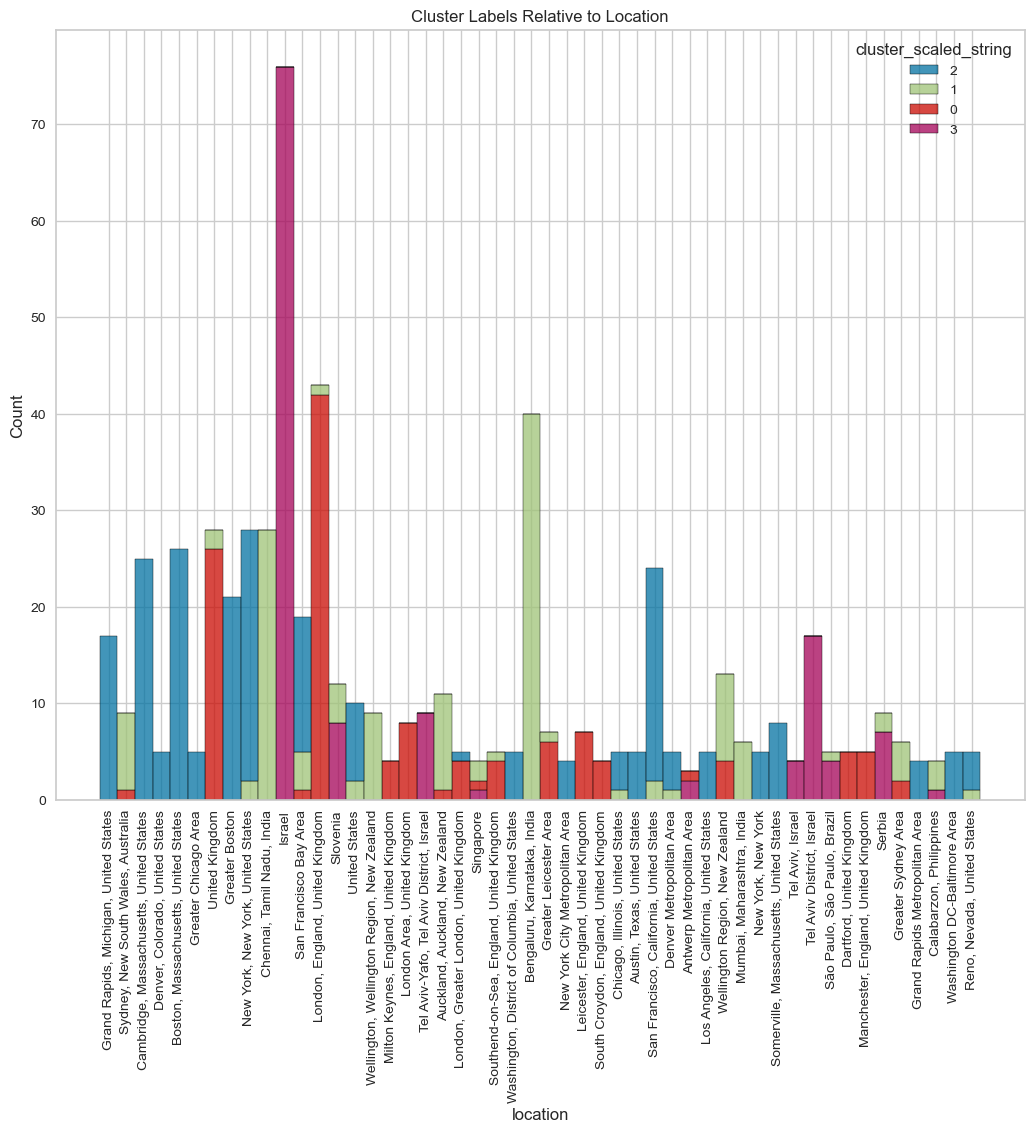

In [86]:

visualize_top_15_category_histogram(overall_results,
                                    category_column="location",
                                    cluster_column="cluster_scaled_string"
                                    ,top=50,
                                    title="Cluster Labels Relative to Location",
                                    width=1000,
                                    height=800
                                    )


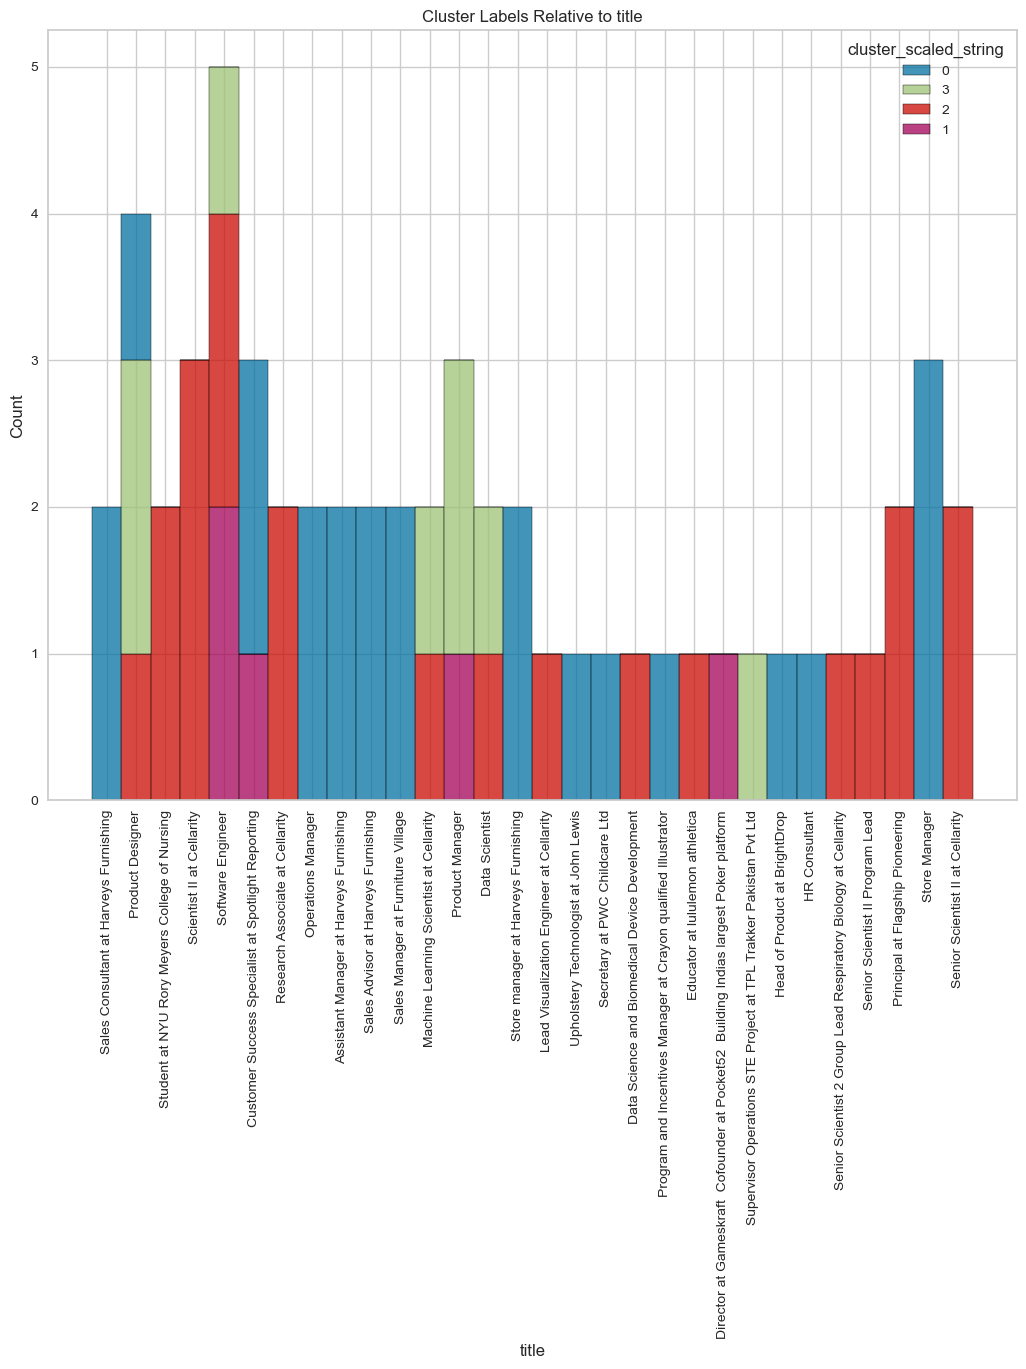

In [87]:

visualize_top_15_category_histogram(overall_results,
                                    category_column="title",
                                    cluster_column="cluster_scaled_string",
                                    top=30,
                                    title="Cluster Labels Relative to title",
                                    width=1000,
                                    height=800
                                    )


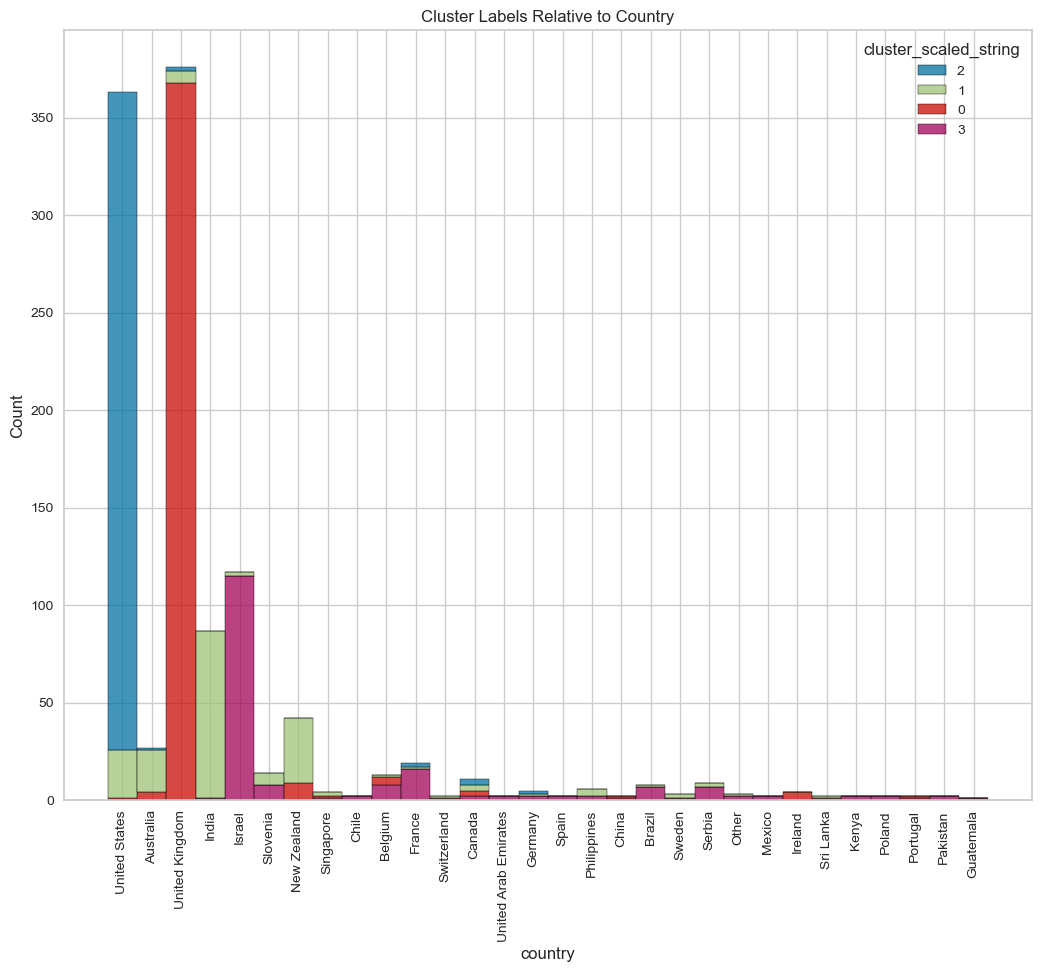

In [88]:

visualize_top_15_category_histogram(overall_results,
                                    category_column="country",
                                    cluster_column="cluster_scaled_string",
                                    top=30,
                                    title="Cluster Labels Relative to Country",
                                    width=1000,
                                    height=800

                                    )


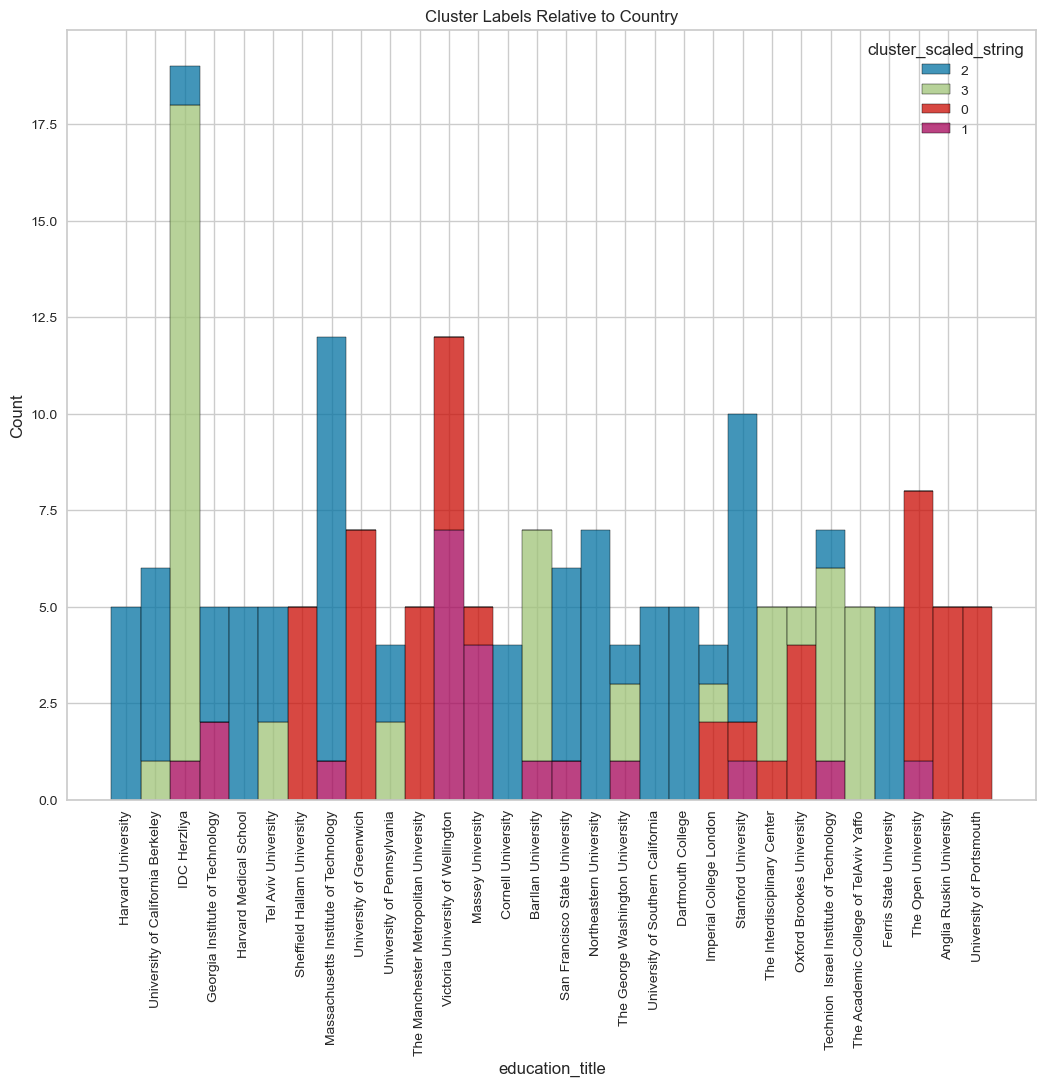

In [89]:


visualize_top_15_category_histogram(overall_results,
                                    category_column="education_title",
                                    cluster_column="cluster_scaled_string",
                                    top=30,
                                    title="Cluster Labels Relative to Country",
                                    width=1000,
                                    height=800
                                    )


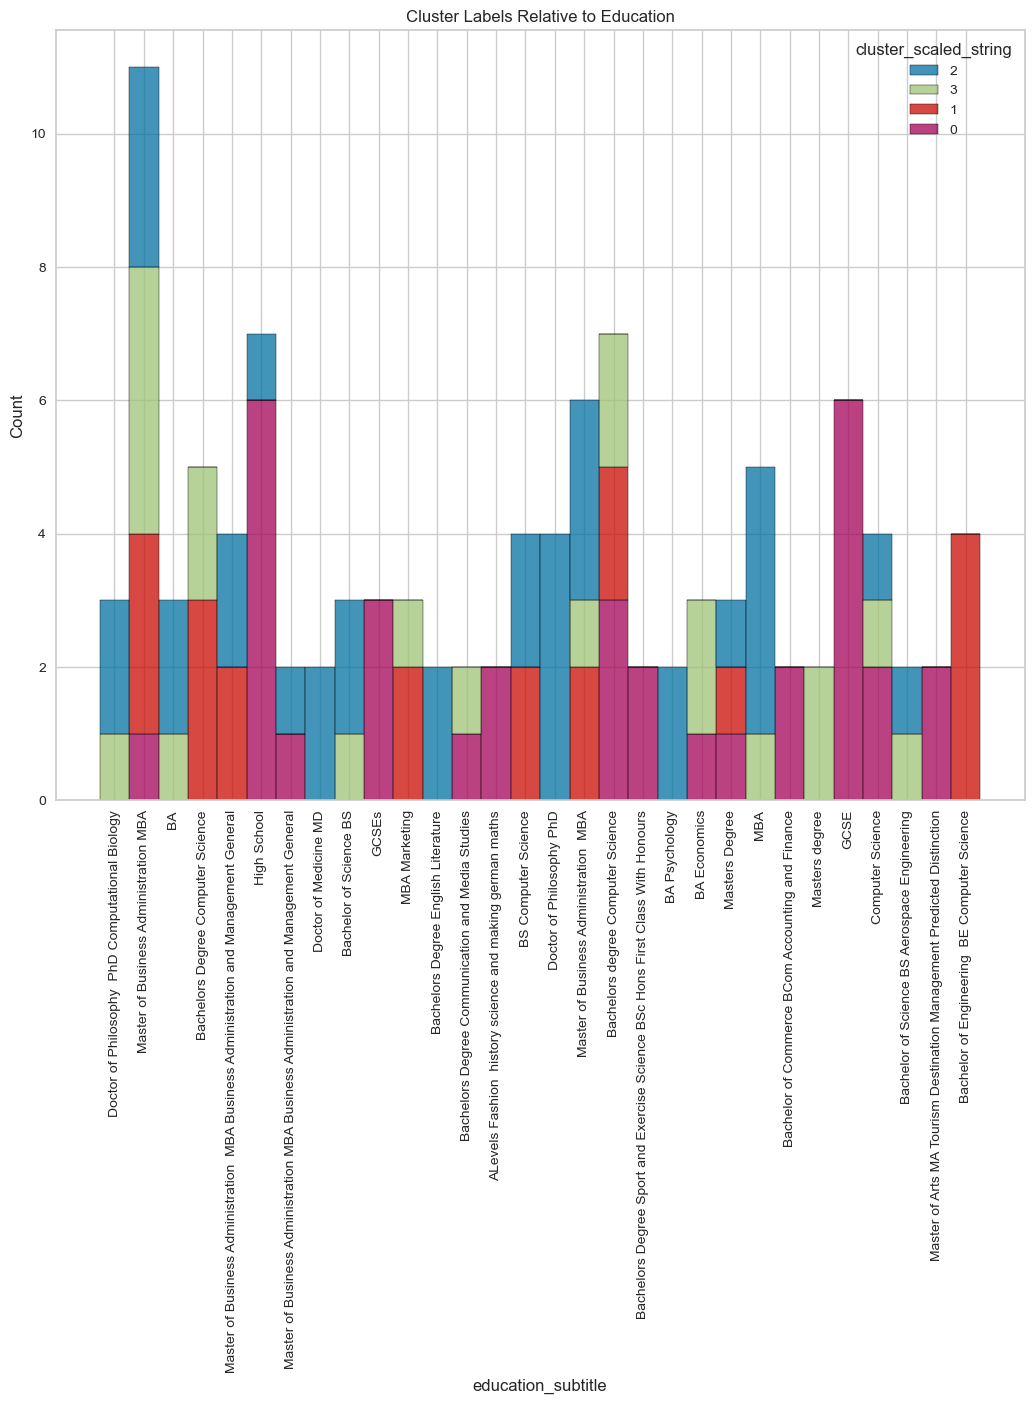

In [90]:


visualize_top_15_category_histogram(overall_results,
                                    category_column="education_subtitle",
                                    cluster_column="cluster_scaled_string",
                                    top=30,
                                    title="Cluster Labels Relative to Education",
                                    width=1000,
                                    height=800
                                    )



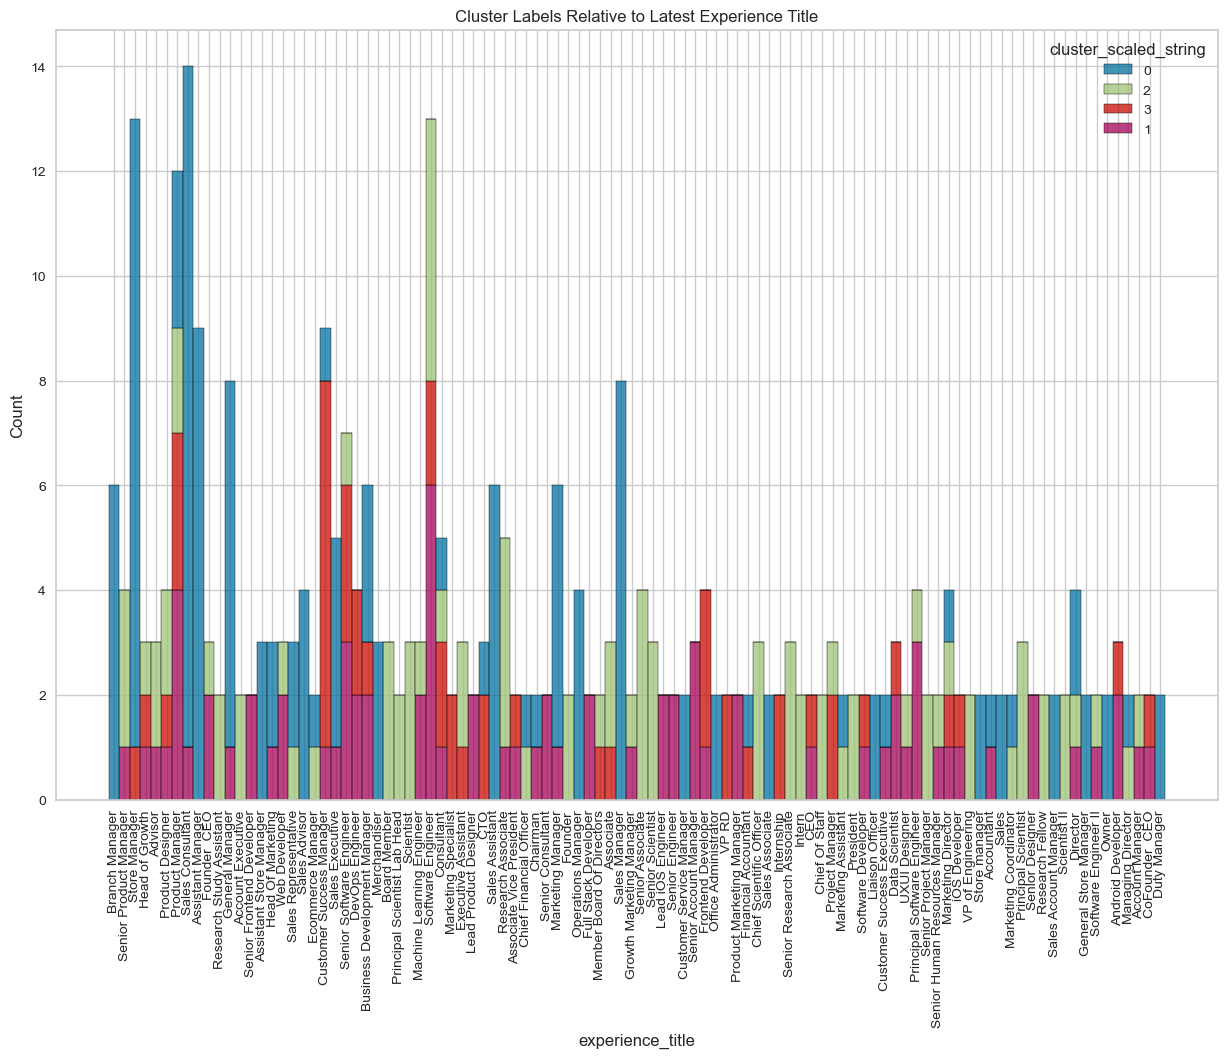

In [91]:
visualize_top_15_category_histogram(overall_results,
                                    category_column="experience_title",
                                    cluster_column="cluster_scaled_string",
                                    top=100,
                                    title="Cluster Labels Relative to Latest Experience Title",
                                    width=1200,
                                    height=800
                                    )

In [92]:

overall_results.to_csv("Clean Data/overall_results.csv",index=False)


### Observations:

- By implementing dimensionality reduction on the merged high-dimensional textual feature embeddings, K-means has shown promising performance, with a Distortion Score of 152 and a Silhouette Score of 0.5201, which we regard as a respectable starting point or baseline model.
- The quality of clustering can potentially be enhanced with the extraction of more features, such as recommendations, as well as educational and professional experiences.
- The model has demonstrated its capability to cluster employees from similar industries, as observed in cluster 2 where retail and furniture sectors have been grouped together.
- In terms of geographic structure, the model has been successful in grouping together locations within the same country. For example, Israel and its districts and cities were combined into cluster 0, a pattern which was also observed with US cities in cluster 1.
Given these observations, the data appears to be well-suited for hierarchical clustering models like HDBSCAN.
- It's notable that the model tends to cluster empty values, "none," or "other" embeddings together, primarily due to their similar extracted embedding vectors. To avoid this, I have chosen to exclude them.
- It's worth noting that K-means, a rather straightforward model that is susceptible to outliers, was used here. As a future endeavor, there's potential to develop this basic model into a more intricate one that is more robust to outliers.

